In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [2]:
import os

In [4]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('mnist/', download=True, train=True, transform=transform)
valset = datasets.MNIST('mnist/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100.1%

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


113.5%

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


100.4%

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


180.4%

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/home/dhorna/anaconda3/envs/mgr/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


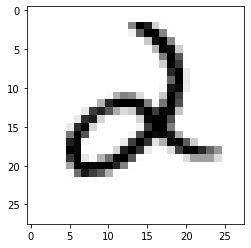

In [6]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

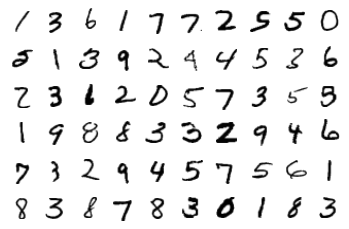

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [8]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [10]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [11]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0029, -0.0029, -0.0029,  ..., -0.0029, -0.0029, -0.0029],
        [ 0.0051,  0.0051,  0.0051,  ...,  0.0051,  0.0051,  0.0051],
        [ 0.0061,  0.0061,  0.0061,  ...,  0.0061,  0.0061,  0.0061],
        ...,
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [ 0.0025,  0.0025,  0.0025,  ...,  0.0025,  0.0025,  0.0025],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003]],
       device='cuda:0')


In [12]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [13]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images.cuda())
loss = criterion(output, labels.cuda())
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0184,  0.0255, -0.0126,  ..., -0.0174, -0.0313, -0.0327],
        [ 0.0353,  0.0114, -0.0284,  ..., -0.0031,  0.0146,  0.0239],
        [ 0.0220, -0.0156,  0.0007,  ...,  0.0099, -0.0057, -0.0324],
        ...,
        [ 0.0116, -0.0186, -0.0217,  ..., -0.0049,  0.0252, -0.0139],
        [ 0.0356,  0.0306,  0.0210,  ...,  0.0099,  0.0344, -0.0295],
        [ 0.0321, -0.0049,  0.0162,  ..., -0.0002,  0.0271,  0.0173]],
       device='cuda:0', requires_grad=True)
Gradient - tensor([[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
        [0.0044, 0.0044, 0.0044,  ..., 0.0044, 0.0044, 0.0044],
        [0.0058, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        ...,
        [0.0017, 0.0017, 0.0017,  ..., 0.0017, 0.0017, 0.0017],
        [0.0015, 0.0015, 0.0015,  ..., 0.0015, 0.0015, 0.0015],
        [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],
       device='cuda:0')


In [14]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0184,  0.0255, -0.0126,  ..., -0.0174, -0.0313, -0.0327],
        [ 0.0352,  0.0113, -0.0285,  ..., -0.0031,  0.0146,  0.0239],
        [ 0.0219, -0.0157,  0.0006,  ...,  0.0098, -0.0058, -0.0324],
        ...,
        [ 0.0116, -0.0186, -0.0217,  ..., -0.0050,  0.0251, -0.0139],
        [ 0.0356,  0.0306,  0.0209,  ...,  0.0099,  0.0344, -0.0295],
        [ 0.0321, -0.0049,  0.0162,  ..., -0.0002,  0.0271,  0.0173]],
       device='cuda:0', requires_grad=True)


In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6450881515262223
Epoch 1 - Training loss: 0.28236872551919046
Epoch 2 - Training loss: 0.22074233632145532
Epoch 3 - Training loss: 0.17884141369375275
Epoch 4 - Training loss: 0.1485962546281596
Epoch 5 - Training loss: 0.12775253482373444
Epoch 6 - Training loss: 0.11203776882774731
Epoch 7 - Training loss: 0.09987021156691953
Epoch 8 - Training loss: 0.08814812174835392
Epoch 9 - Training loss: 0.07989294918279832
Epoch 10 - Training loss: 0.07266831919173601
Epoch 11 - Training loss: 0.06555813406559347
Epoch 12 - Training loss: 0.06056984554855093
Epoch 13 - Training loss: 0.05648082749707612
Epoch 14 - Training loss: 0.05191291364799462

Training Time (in minutes) = 2.1628945310910543


In [16]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 0


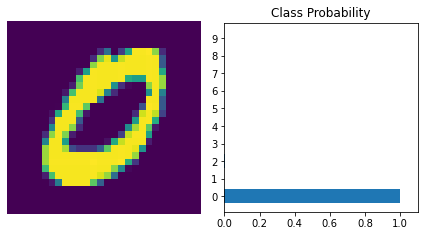

In [17]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [18]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img.cuda())

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9729
